## Data Preprocessing

In [20]:
# Import the libraries
import os
import numpy as np 
import pandas as pd 
import c_visuals as vs
import matplotlib.pyplot as plt
import seaborn as sns  
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# Change working directory
os.chdir('C:/Users/User/Desktop/Data&Code/Insurance/Insurance_2018')

In [8]:
# Import Data
Insurance = pd.read_excel('INSURANCE_2018_20200331_V1.xlsx')

# Create Product_sub_Category 
Insurance['Product_sub_Category'] = Insurance['Insure_Company'] + '_' + Insurance['Product_Category']

# Group by created variables
bins = [0, 20, 40, 50, 60, 70, 120]
labels = ['0-19', '20-39', '40-49', '50-59', '60-69','70+']
Insurance_flat = Insurance.groupby(['Customer_ID','Product_Category'])['Buy_Amount'].sum().unstack()
Insurance_flat['Buy_Amount'] = Insurance.groupby(['Customer_ID'])['Buy_Amount'].sum()
Insurance_flat['Age'] = Insurance.groupby(['Customer_ID'])['Age'].first()
Insurance_flat.fillna(value=1, inplace=True)

# Age bin
Insurance_flat['Age_bins'] = pd.cut(x=Insurance_flat['Age'], bins = bins, labels = labels,include_lowest = True)
Insurance_flat.head()

Product_Category,Others,保險附約,定期壽險,定期醫療,年金保險,意外傷害,終身壽險,終身還本,終身醫療,萬能壽險,長照險,Buy_Amount,Age,Age_bins
Customer_ID,,,,,,,,,,,,,,
A103717610,1.0,1.0,1.0,1.0,1.0,1.0,9840.0,1.0,1.0,1.0,1.0,9840,66,60-69
A120502113,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,29720.0,29720,46,40-49
A121900382,1.0,1.0,1.0,1.0,10000.0,1.0,1.0,1.0,1.0,1.0,1.0,10000,50,40-49
A122597969,1.0,1.0,1.0,1.0,1.0,1.0,4536.0,1.0,1.0,1.0,1.0,4536,61,60-69
A122755416,1.0,1.0,1.0,1.0,1000000.0,1.0,1.0,1.0,1.0,1.0,1.0,1000000,55,50-59


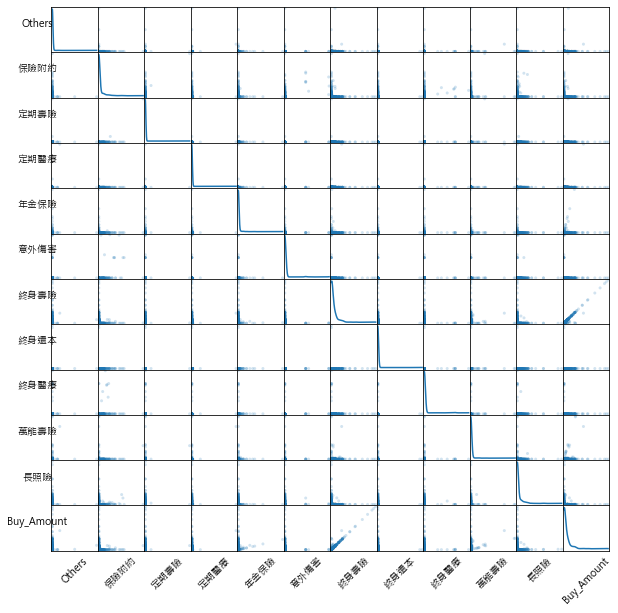

In [9]:
# Scatter_matrix plot of all features
Insurance_flat_numeric = Insurance_flat.iloc[:,:-2]
sm = pd.plotting.scatter_matrix(Insurance_flat_numeric, alpha=0.2, figsize=(10, 10), diagonal = 'kde')

# Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

# May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.3,0.5) for s in sm.reshape(-1)]

# Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

# plt.show()
plt.savefig('Insurance_2018_Var.png')

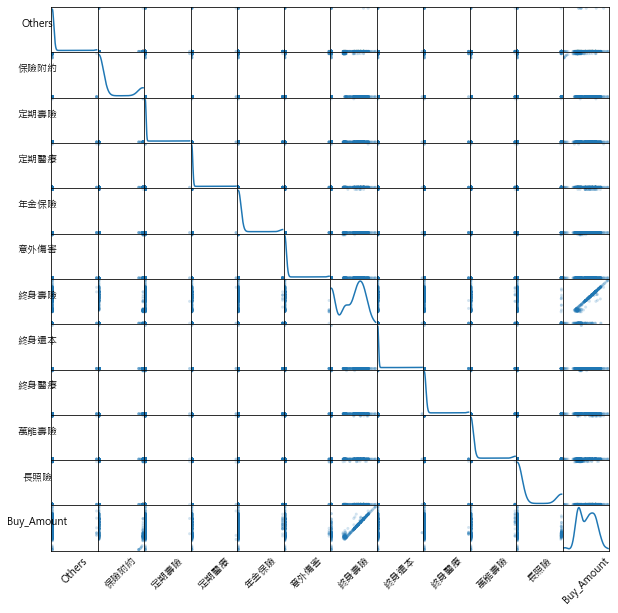

In [10]:
# Scale the data using the Box Cox method
from sklearn.preprocessing import PowerTransformer

bc = PowerTransformer(method='box-cox')
Insurance_scaled_features = bc.fit_transform(Insurance_flat_numeric.values)
Insurance_scaled_features_df = pd.DataFrame(Insurance_scaled_features, index=Insurance_flat_numeric.index,\
                                         columns=Insurance_flat_numeric.columns)
sm = pd.plotting.scatter_matrix(Insurance_scaled_features_df, alpha=0.2, figsize=(10, 10), diagonal = 'kde')

# Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

# May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.3,0.5) for s in sm.reshape(-1)]

# Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

# plt.show()
plt.savefig('Insurance_2018_Var_Norm_2.png')

In [11]:
# Age df
Age_df = Insurance_flat.groupby('Age_bins').size().to_frame(name = 'Size')
Age_df['Buy_Amount'] = Insurance_flat.groupby('Age_bins')['Buy_Amount'].sum()
Age_df

,Size,Buy_Amount
Age_bins,,
0-19,43,6549977
20-39,129,43568608
40-49,158,79275122
50-59,136,153680824
60-69,54,43023045
70+,18,6732185


Text(0.5, 1.0, 'Insurance_2018_Age_distribution')

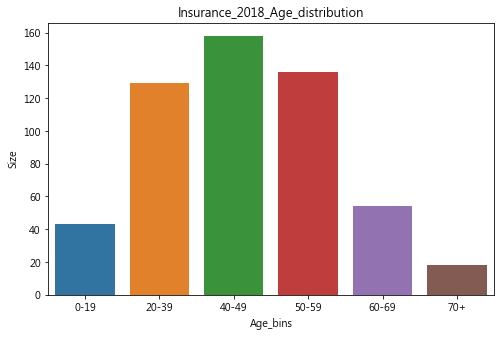

In [12]:
# Plot age distribution
plt.figure(figsize = (8,5))
sns.barplot(x = Age_df.index,y = Age_df['Size'])
plt.title('Insurance_2018_Age_distribution')

Text(0.5, 1.0, 'Insurance_2018_Age_buy_amount')

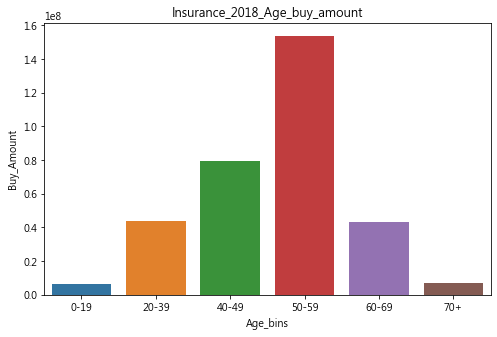

In [13]:
# Age_bin vs. Buy_amount barplot
plt.figure(figsize = (8,5))
sns.barplot(x = Age_df.index, y = Age_df.Buy_Amount)
plt.title('Insurance_2018_Age_buy_amount')

Text(0.5, 1.0, 'Insurance_2018_Age_Average_buy_amount')

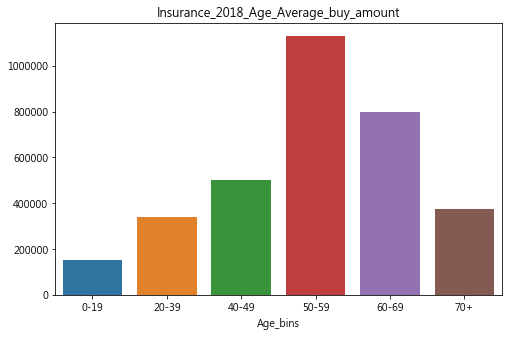

In [14]:
# Age_bin vs. Buy_amount barplot
plt.figure(figsize = (8,5))
sns.barplot(x = Age_df.index, y = Age_df.Buy_Amount / Age_df.Size)
plt.title('Insurance_2018_Age_Average_buy_amount')

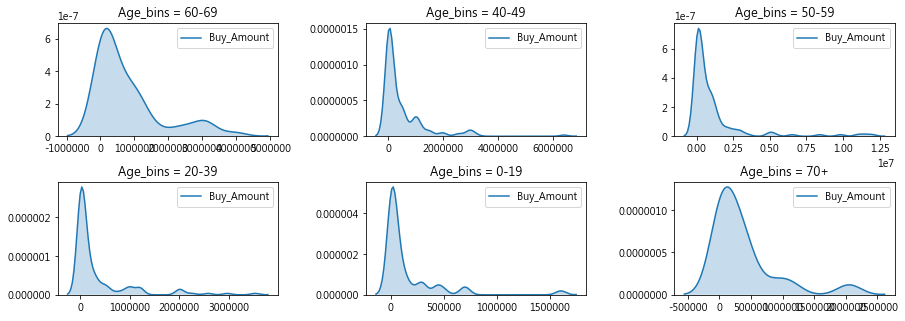

In [16]:
# Age bin kde plot
fig , ax = plt.subplots(figsize = (15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i,j in enumerate(Insurance_flat.Age_bins.unique()):
    plt.subplot(2, 3, i+1)
    filter_ = Insurance_flat['Age_bins'] == j
    sns.kdeplot(Insurance_flat.loc[filter_].Buy_Amount, shade=True)
    plt.title("Age_bins = {}" .format(j))

## Outlier Detection

In [18]:
# Outlier detection
import xlsxwriter

# Create a new df with the descriptive features
Insurance_feat_w_prop_df = Insurance_flat_numeric
# Insurance_feat_w_prop_df['Customer_Name'] = Insurance.groupby(['Customer_ID'])['Customer_Name'].first()
Insurance_feat_w_prop_df['Age'] = Insurance.groupby(['Customer_ID'])['Age'].first()
Insurance_feat_w_prop_df['Gender'] = Insurance.groupby(['Customer_ID'])['Gender'].first()
Insurance_feat_w_prop_df['Constellation'] = Insurance.groupby(['Customer_ID'])['Constellation'].first()
Insurance_feat_w_prop_df['Buy_Amount'] = Insurance.groupby(['Customer_ID'])['Buy_Amount'].sum()
Insurance_feat_w_prop_df['Com_ID'] = Insurance.groupby(['Customer_ID'])['Com_ID'].first()
Insurance_feat_w_prop_df['Sales_ID'] = Insurance.groupby(['Customer_ID'])['Com_ID'].first()
Insurance_feat_w_prop_df['Sales_Name'] = Insurance.groupby(['Customer_ID'])['Com_ID'].first()

feature_outliers = []
writer = pd.ExcelWriter('Insurance_2018_Outliers_sheets.xlsx', engine='xlsxwriter')

for feature in Insurance_scaled_features_df.keys():
    Q1 = np.percentile(Insurance_scaled_features_df[feature], 25)
    Q3 = np.percentile(Insurance_scaled_features_df[feature], 75)
    step = 1.5*(Q3 - Q1)
    Outlier_Index = ~((Insurance_scaled_features_df[feature] >= Q1 - step)&\
                       (Insurance_scaled_features_df[feature] <= Q3 + step))
    Insurance_feat_w_prop_df.loc[Insurance_scaled_features_df.loc[Outlier_Index].index,:].groupby(['Customer_ID']).first()\
    .to_excel(writer, sheet_name = feature)
    feature_outliers.append(Insurance_feat_w_prop_df.loc[Insurance_scaled_features_df.loc[Outlier_Index].index,:])
writer.save()

# Flatten list of outliers
outliers_flattened = []

for i, j in enumerate(feature_outliers):
    outliers_flattened.append(feature_outliers[i].index)
flat_list = [item for sublist in outliers_flattened for item in sublist]

# Count the number of features for which a given observation is considered an outlier
from collections import Counter
outlier_count = Counter(flat_list)
outliers = [observation for observation in outlier_count.elements() if outlier_count[observation] >= 3]
Insurance_feat_w_prop_df.loc[Insurance_scaled_features_df.loc[outliers].index,:].groupby(['Customer_ID']).first()\
.to_csv('Insurance_2018_Outliers.csv', encoding='utf_8_sig')

## PCA vs. SVD

,Explained Var,Others,保險附約,定期壽險,定期醫療,年金保險,意外傷害,終身壽險,終身還本,終身醫療,萬能壽險,長照險,Buy_Amount
Dim 1,0.1977,0.0342,0.3538,0.0536,0.0185,-0.0156,0.1515,-0.5865,0.0367,0.1436,-0.0476,0.3815,-0.5775
Dim 2,0.1139,0.3130,-0.5104,-0.0140,0.3619,0.1328,-0.3701,-0.2484,0.0530,-0.2752,0.2891,0.3627,0.0185
Dim 3,0.1037,0.4181,0.3219,0.3566,0.4433,-0.1336,0.1909,0.0551,-0.0857,0.1574,0.4647,-0.2969,0.0663
Dim 4,0.0928,-0.4186,0.0008,0.5856,-0.3462,0.3644,-0.1307,-0.1346,0.0134,-0.0217,0.4333,0.0041,0.0741
Dim 5,0.0892,-0.1495,-0.0697,0.3153,-0.0717,-0.6957,0.2040,0.1490,-0.1557,-0.4071,0.0432,0.3581,0.0182
Dim 6,0.0848,-0.0530,-0.0438,0.1110,-0.0530,-0.4834,-0.5637,0.0315,0.3714,0.5367,0.0238,0.0002,-0.0330
Dim 7,0.0837,0.0189,0.0299,0.0135,0.0062,0.0062,0.2667,-0.0072,0.8937,-0.3327,0.0375,-0.1273,-0.0152
Dim 8,0.0723,0.4327,0.1179,0.5291,-0.1220,0.1356,-0.2932,0.0705,-0.0083,-0.2324,-0.5734,-0.0804,-0.0733
Dim 9,0.0666,-0.4873,-0.0306,0.2603,0.6961,0.1504,0.0655,0.0937,0.0692,0.1356,-0.3537,0.1397,0.0764
Dim 10,0.0627,0.3058,-0.3016,0.1874,-0.2110,0.1031,0.4597,0.0023,0.1060,0.4744,-0.1153,0.3809,0.3453


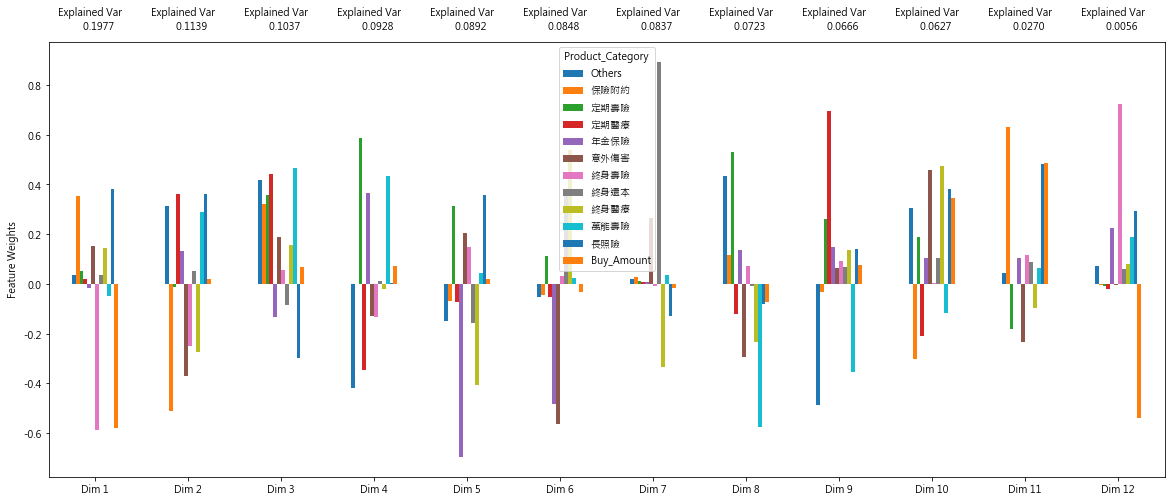

In [21]:
# PCA
from sklearn.decomposition import PCA

# Apply PCA by fitting the good data with the same number of dimensions as features
num_features = Insurance_scaled_features_df.shape[1]
pca = PCA(n_components = num_features, random_state = 0)
pca = pca.fit(Insurance_scaled_features_df)

# Transform log_samples using the PCA fit above

# Generate PCA results plot
vs.pca_results(Insurance_scaled_features_df, pca)

,Explained Var,Others,保險附約,定期壽險,定期醫療,年金保險,意外傷害,終身壽險,終身還本,終身醫療,萬能壽險,長照險,Buy_Amount
Dim 1,0.1977,0.0342,0.3538,0.0536,0.0185,-0.0156,0.1515,-0.5865,0.0367,0.1436,-0.0476,0.3815,-0.5775
Dim 2,0.1139,0.3130,-0.5104,-0.0140,0.3619,0.1328,-0.3701,-0.2484,0.0530,-0.2752,0.2891,0.3627,0.0185
Dim 3,0.1037,0.4181,0.3219,0.3566,0.4433,-0.1336,0.1909,0.0551,-0.0857,0.1574,0.4647,-0.2969,0.0663
Dim 4,0.0928,-0.4186,0.0008,0.5856,-0.3462,0.3644,-0.1307,-0.1346,0.0134,-0.0217,0.4333,0.0041,0.0741
Dim 5,0.0892,-0.1495,-0.0697,0.3153,-0.0717,-0.6957,0.2040,0.1490,-0.1557,-0.4071,0.0432,0.3581,0.0182
Dim 6,0.0848,-0.0530,-0.0438,0.1110,-0.0530,-0.4834,-0.5637,0.0315,0.3714,0.5367,0.0238,0.0002,-0.0330
Dim 7,0.0837,0.0189,0.0299,0.0135,0.0062,0.0062,0.2667,-0.0072,0.8937,-0.3327,0.0375,-0.1273,-0.0152
Dim 8,0.0723,0.4327,0.1179,0.5291,-0.1220,0.1356,-0.2932,0.0705,-0.0083,-0.2324,-0.5734,-0.0804,-0.0733
Dim 9,0.0666,-0.4873,-0.0306,0.2603,0.6961,0.1504,0.0655,0.0937,0.0692,0.1356,-0.3537,0.1397,0.0764
Dim 10,0.0627,0.3058,-0.3016,0.1874,-0.2110,0.1031,0.4597,0.0023,0.1060,0.4744,-0.1153,0.3809,0.3453


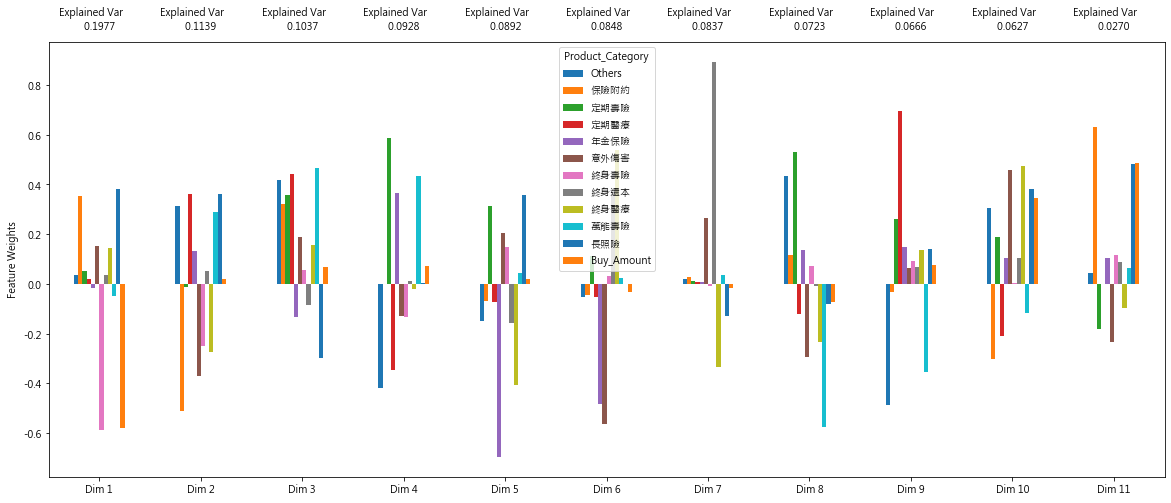

In [22]:
# SVD
from sklearn.decomposition import TruncatedSVD

# Apply PCA by fitting the good data with the same number of dimensions as features
num_features = Insurance_scaled_features_df.shape[1] - 1
svd = TruncatedSVD(n_components = num_features, random_state = 0)
svd = svd.fit(Insurance_scaled_features_df)

# Transform log_samples using the PCA fit above

# Generate PCA results plot
vs.pca_results(Insurance_scaled_features_df, svd)

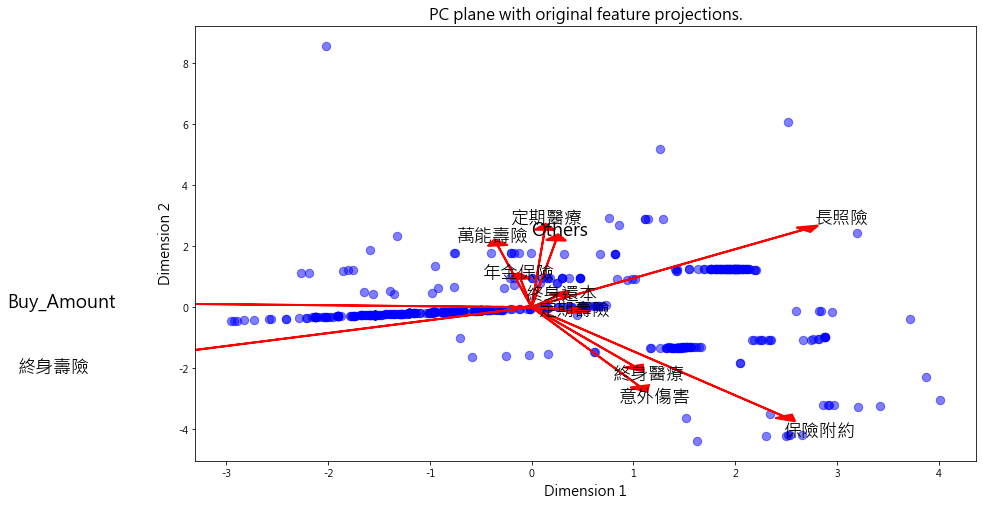

In [23]:
# Apply PCA by fitting data with only 2 Dimensions
pca = PCA(n_components = 2, random_state = 0)
pca = pca.fit(Insurance_scaled_features_df)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(Insurance_scaled_features_df)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

vs.biplot(Insurance_scaled_features_df ,reduced_data, pca)

## K means Clustering

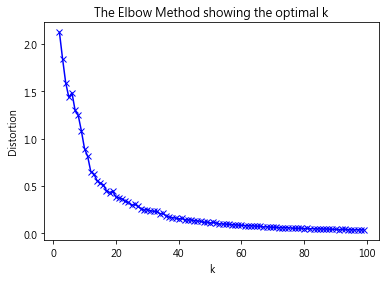

In [25]:
# clustering dataset
# determine k using elbow method

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

# k means determine k
distortions = []
K = range(2,100)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(Insurance_scaled_features_df)
    distortions.append(sum(np.min(cdist(Insurance_scaled_features_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / \
                       Insurance_scaled_features_df.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

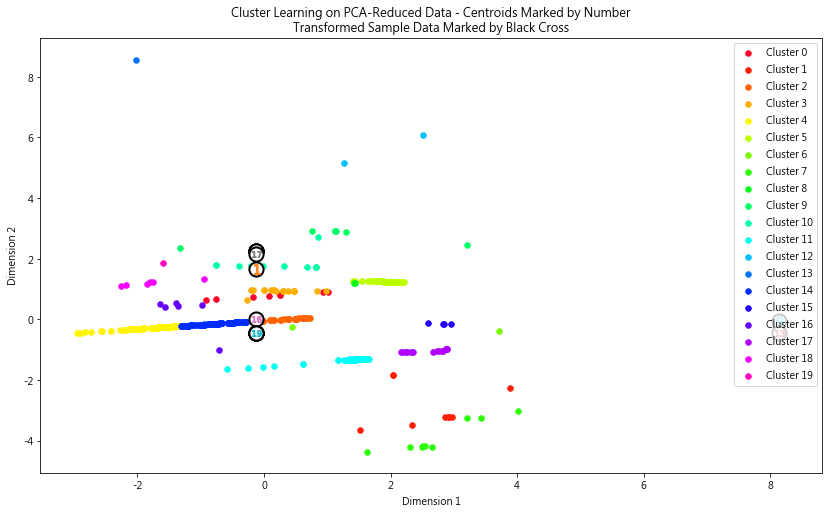

In [26]:
# Clustering(Elbow_method)
optimized_kmeans = KMeans(n_clusters = 20, random_state = 0).fit(Insurance_scaled_features_df)
kmeans_preds = optimized_kmeans.predict(Insurance_scaled_features_df)
kmeans_centers = optimized_kmeans.cluster_centers_
vs.cluster_results(reduced_data, kmeans_preds, kmeans_centers)

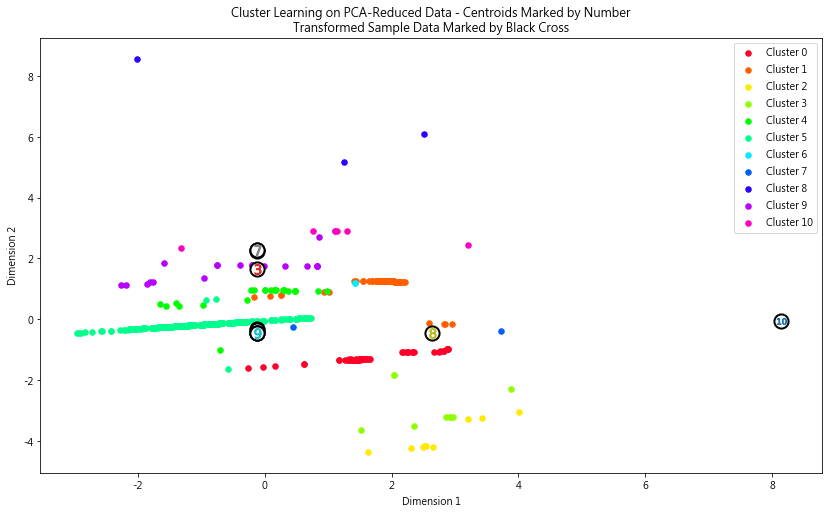

In [28]:
# Clustering(silhouette_score method)
# Clustering(silhouette_score method)
# silhouette_score method
num_clusters = np.arange(2,30)
kmeans_results = {}
for size in num_clusters:
    kmeans = KMeans(n_clusters = size).fit(Insurance_scaled_features_df)
    preds = kmeans.predict(Insurance_scaled_features_df)
    kmeans_results[size] = metrics.silhouette_score(Insurance_scaled_features_df, preds)
    
best_size = max(kmeans_results, key = kmeans_results.get)

optimized_kmeans = KMeans(n_clusters = best_size, random_state = 0).fit(Insurance_scaled_features_df)
kmeans_preds = optimized_kmeans.predict(Insurance_scaled_features_df)
kmeans_centers = optimized_kmeans.cluster_centers_
vs.cluster_results(reduced_data, kmeans_preds, kmeans_centers)

For n_clusters = 2 The average silhouette_score is : 0.38382832820813956
For n_clusters = 3 The average silhouette_score is : 0.4567113770960654
For n_clusters = 4 The average silhouette_score is : 0.5192081610373713
For n_clusters = 5 The average silhouette_score is : 0.5454121719867256
For n_clusters = 6 The average silhouette_score is : 0.610050528356478
For n_clusters = 7 The average silhouette_score is : 0.5973487847599368
For n_clusters = 8 The average silhouette_score is : 0.6136568650633248
For n_clusters = 9 The average silhouette_score is : 0.6659945163161293
For n_clusters = 10 The average silhouette_score is : 0.676920343387714
For n_clusters = 11 The average silhouette_score is : 0.7091005318953362
For n_clusters = 12 The average silhouette_score is : 0.6185563947958491
For n_clusters = 13 The average silhouette_score is : 0.6189558787551223
For n_clusters = 14 The average silhouette_score is : 0.6192210301157217
For n_clusters = 15 The average silhouette_score is : 0.6283

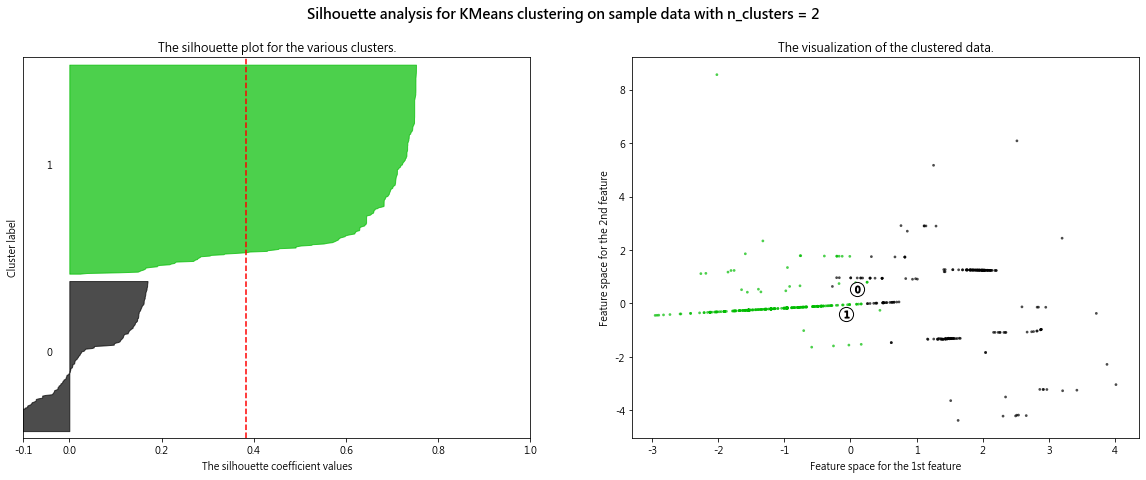

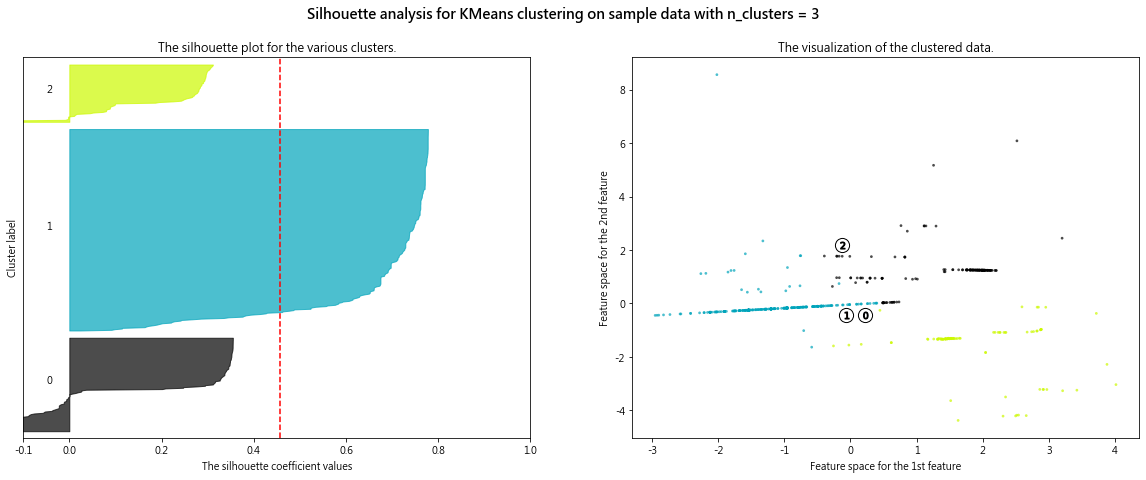

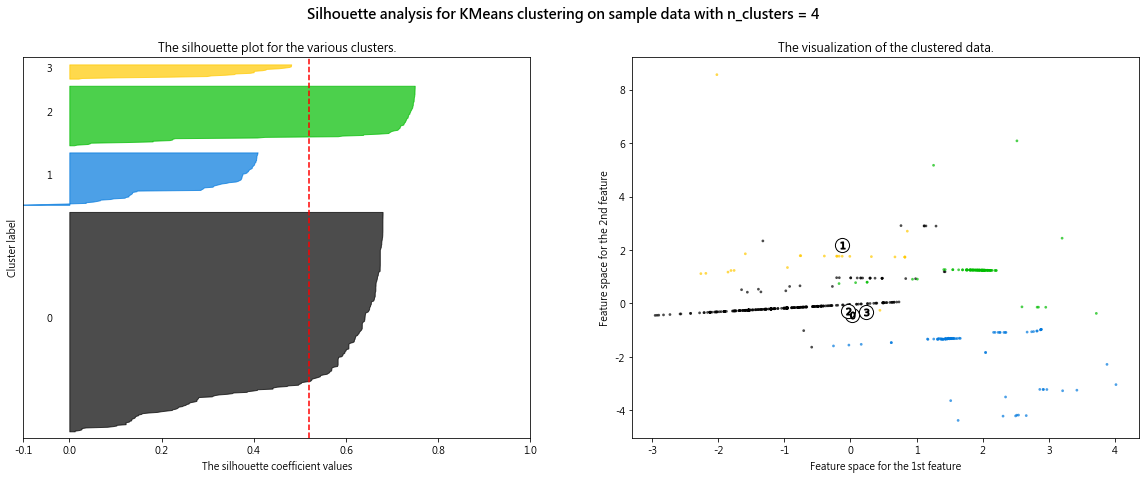

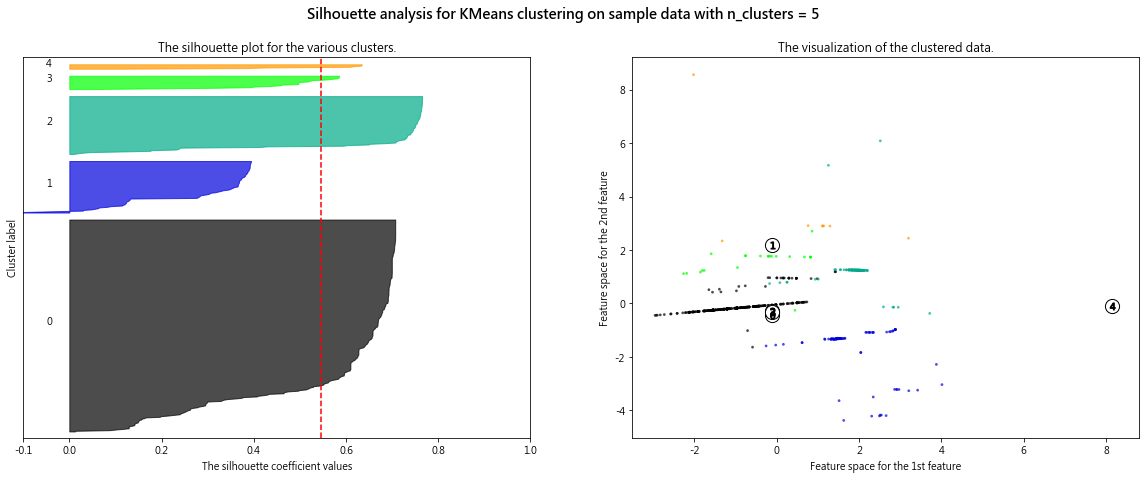

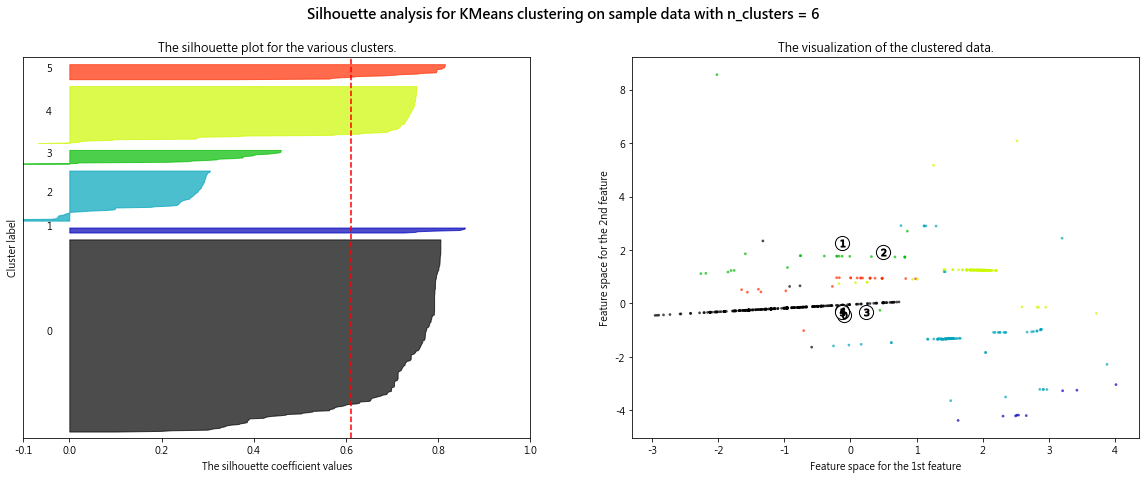

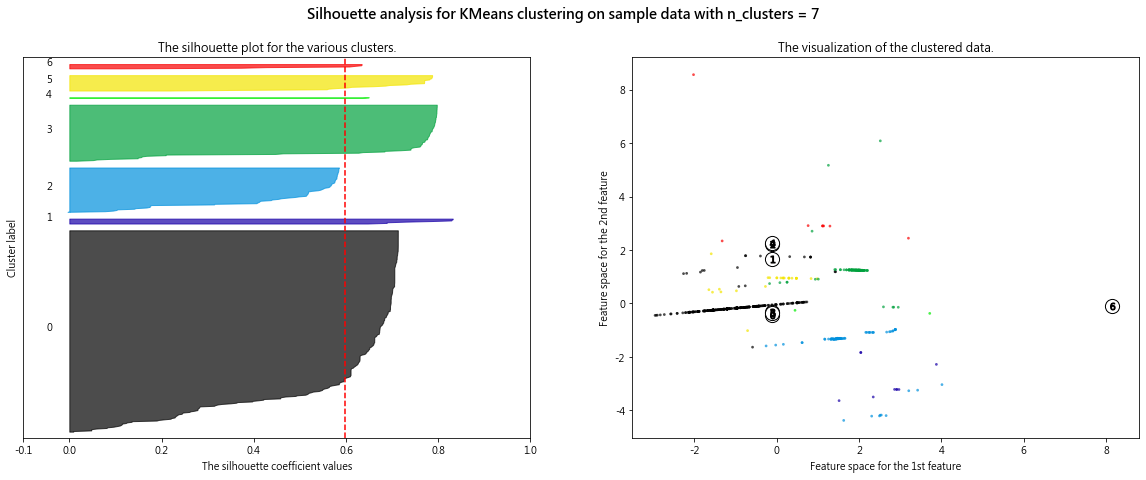

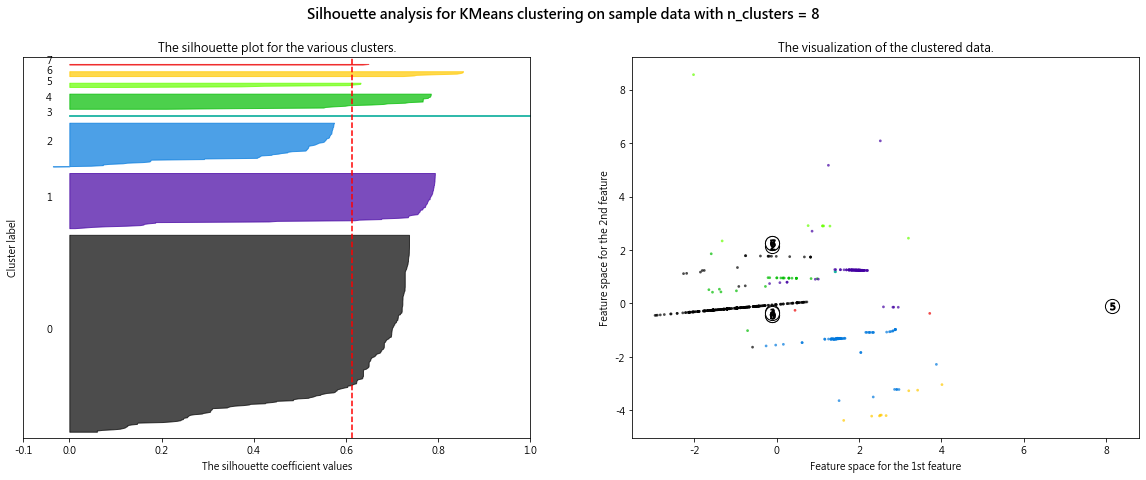

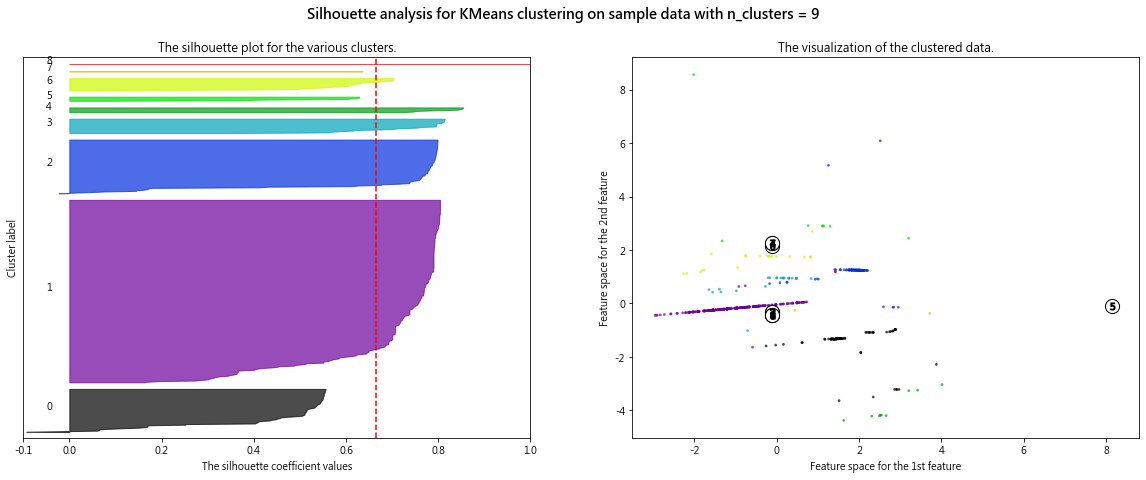

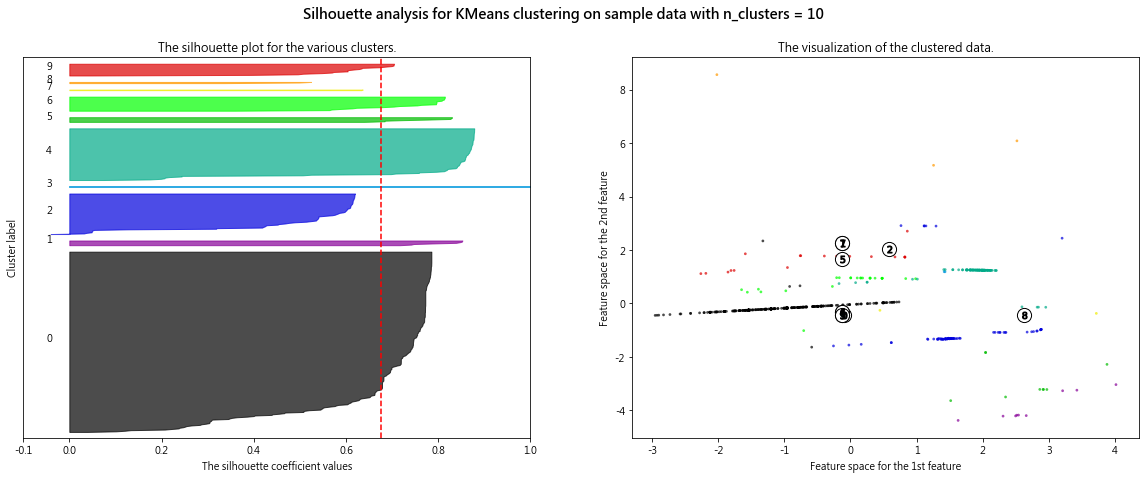

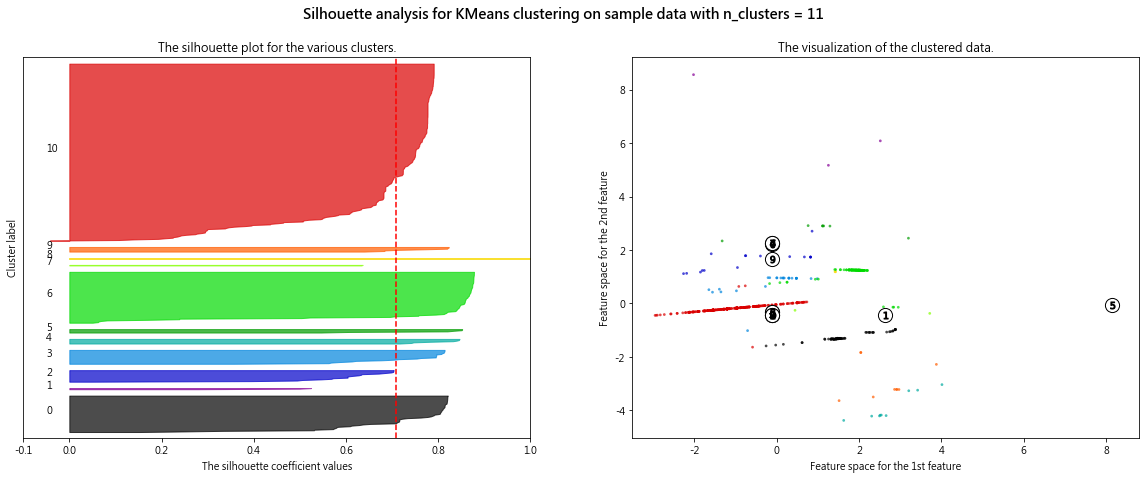

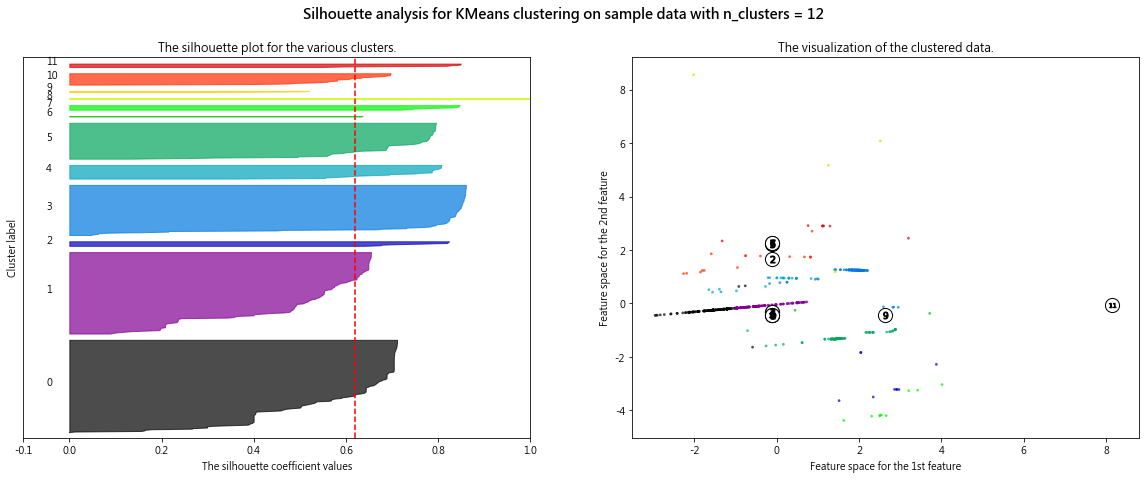

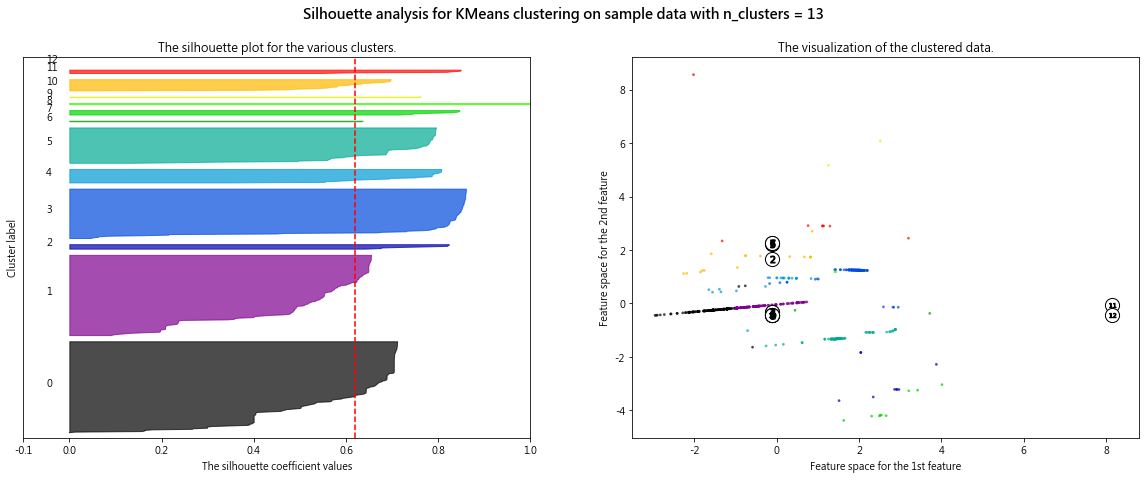

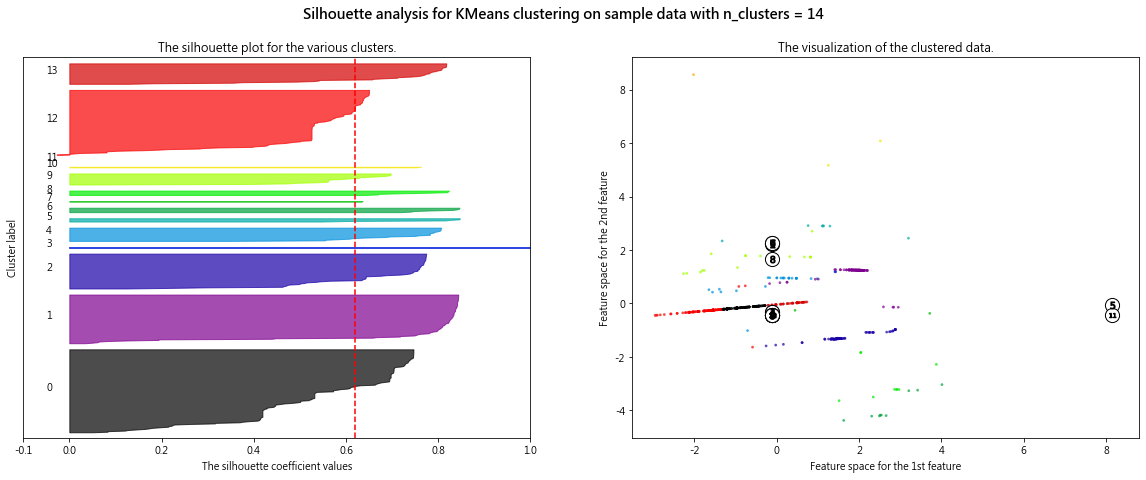

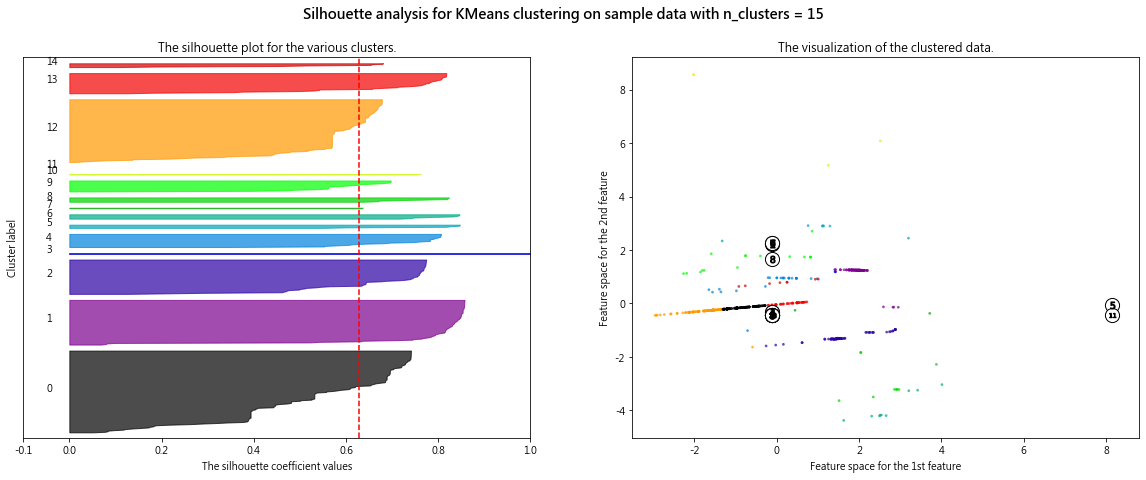

In [30]:
# silhouette_score plot
vs.Silhouette_score(r = 16, df = Insurance_scaled_features_df, reduced_df = reduced_data)
plt.savefig('Insurance_2018'+ '_Silhouette_score' + '.png')

## K Prototype Clustering

In [31]:
Insurance_scaledfeat_w_prop_df = Insurance_scaled_features_df
Insurance_scaledfeat_w_prop_df['Age_bins'] = Insurance_flat['Age_bins']
Insurance_scaledfeat_w_prop_df['Gender'] = Insurance.groupby(['Customer_ID'])['Gender'].first()
Insurance_scaledfeat_w_prop_df['Constellation'] = Insurance.groupby(['Customer_ID'])['Constellation'].first()
Insurance_scaledfeat_w_prop_df['Com_ID'] = Insurance.groupby(['Customer_ID'])['Com_ID'].first()
Insurance_scaledfeat_w_prop_df['Sales_ID'] = Insurance.groupby(['Customer_ID'])['Sales_ID'].first()
Insurance_scaledfeat_w_prop_df.head()

Product_Category,Others,保險附約,定期壽險,定期醫療,年金保險,意外傷害,終身壽險,終身還本,終身醫療,萬能壽險,長照險,Buy_Amount,Age_bins,Gender,Constellation,Com_ID,Sales_ID
Customer_ID,,,,,,,,,,,,,,,,,
A103717610,-0.122859,-0.445071,-0.061085,-0.074883,-0.225347,-0.130435,-0.186061,-0.061085,-0.130435,-0.21133,-0.474879,-1.069740,60-69,MALE,天蠍座,585U,4205
A120502113,-0.122859,-0.445071,-0.061085,-0.074883,-0.225347,-0.130435,-1.395689,-0.061085,-0.130435,-0.21133,2.111471,-0.649588,40-49,MALE,射手座,5852,91112
A121900382,-0.122859,-0.445071,-0.061085,-0.074883,4.437601,-0.130435,-1.395689,-0.061085,-0.130435,-0.21133,-0.474879,-1.063906,40-49,MALE,巨蟹座,5854,90132
A122597969,-0.122859,-0.445071,-0.061085,-0.074883,-0.225347,-0.130435,-0.336121,-0.061085,-0.130435,-0.21133,-0.474879,-1.340045,60-69,MALE,摩羯座,585U,82036
A122755416,-0.122859,-0.445071,-0.061085,-0.074883,4.437602,-0.130435,-1.395689,-0.061085,-0.130435,-0.21133,-0.474879,1.003763,50-59,MALE,巨蟹座,5854,96086


Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 137, ncost: 2038.080849301793
Run: 1, iteration: 2/100, moves: 42, ncost: 2029.08588418745
Run: 1, iteration: 3/100, moves: 7, ncost: 2028.122239853416
Run: 1, iteration: 4/100, moves: 2, ncost: 2028.092454204468
Run: 1, iteration: 5/100, moves: 0, ncost: 2028.092454204468
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 44, ncost: 2258.251755034506
Run: 2, iteration: 2/100, moves: 10, ncost: 2246.432348742728
Run: 2, iteration: 3/100, moves: 0, ncost: 2246.432348742728
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 122, ncost: 2967.807870547521
Run: 3, iteration: 2/100, moves: 2

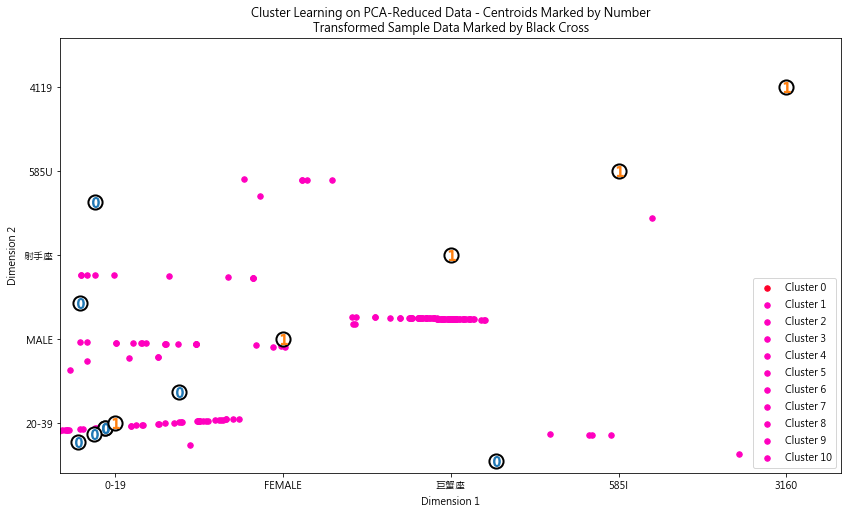

In [32]:
from kmodes.kprototypes import KPrototypes

# K Prototype Clustering
kproto = KPrototypes(n_clusters = best_size, init='Cao', verbose=2)
kproto_preds = kproto.fit_predict(Insurance_scaledfeat_w_prop_df, categorical=[12, 13, 14, 15, 16])
kproto_centers = kproto.cluster_centroids_
vs.cluster_results(reduced_data, kproto_preds, kproto_centers)

## Data Recovery

In [34]:
## K means
# Inverse transform the box-cox centers
true_centers = bc.inverse_transform(kmeans_centers)
true_centers[np.isnan(true_centers)] = 1

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(kmeans_centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = Insurance_scaled_features_df.iloc[:,:12].keys())
true_centers.index = segments
display(true_centers)

# Segment mean
Insurance_flat['Label'] = optimized_kmeans.labels_
display(round(Insurance_flat.groupby('Label').mean()))

C:\Users\User\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2909: RuntimeWarning: divide by zero encountered in power
  x_inv = (x * lmbda + 1) ** (1 / lmbda)


Product_Category,Others,保險附約,定期壽險,定期醫療,年金保險,意外傷害,終身壽險,終身還本,終身醫療,萬能壽險,長照險,Buy_Amount
Segment 0,1.0,481.0,1.0,1.0,1.0,1.0,866.0,1.0,1.0,1.0,1.0,5573.0
Segment 1,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,14120.0,20551.0
Segment 2,1.0,11711.0,1.0,1.0,1.0,inf,2179.0,1.0,1.0,1.0,2.0,28060.0
Segment 3,1.0,8.0,1.0,1.0,1.0,1.0,28.0,1.0,1.0,1.0,1.0,29254.0
Segment 4,1.0,1.0,1.0,1.0,52258.0,1.0,172.0,1.0,1.0,1.0,1.0,281330.0
Segment 5,1.0,1.0,1.0,1.0,1.0,1.0,375635.0,1.0,1.0,1.0,1.0,370687.0
Segment 6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,29359.0
Segment 7,1.0,23534.0,inf,1.0,1.0,1.0,1262.0,1.0,1.0,1.0,3.0,186364.0
Segment 8,1.0,1.0,1.0,inf,1.0,1.0,2006.0,1.0,1.0,1.0,2.0,96097.0
Segment 9,1.0,1.0,1.0,1.0,1.0,1.0,784.0,1.0,1.0,26649.0,1.0,421983.0


Product_Category,Others,保險附約,定期壽險,定期醫療,年金保險,意外傷害,終身壽險,終身還本,終身醫療,萬能壽險,長照險,Buy_Amount,Age
Label,,,,,,,,,,,,,
0,1.0,5743.0,1.0,1.0,1.0,1.0,19842.0,1.0,1.0,1.0,1.0,25584.0,35.0
1,1.0,710.0,1.0,1.0,1.0,1.0,12098.0,1.0,1.0,1.0,22039.0,34845.0,44.0
2,1.0,18172.0,1.0,1.0,1.0,616.0,13282.0,1.0,1.0,1.0,2875.0,34944.0,19.0
3,1.0,6519.0,1.0,1.0,1.0,1.0,11811.0,1.0,16659.0,1.0,1282.0,36269.0,32.0
4,1.0,412.0,1.0,1.0,426168.0,1.0,98530.0,1.0,1.0,1.0,1.0,525109.0,50.0
5,1.0,43.0,1.0,1.0,1.0,1.0,931161.0,1.0,1.0,1.0,112.0,931314.0,48.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,29368.0,1.0,1.0,1.0,29368.0,17.0
7,1.0,33950.0,11810.0,1.0,1.0,1.0,38769.0,1.0,1.0,498638.0,2196.0,585361.0,44.0
8,13036.0,1.0,1.0,26629.0,1.0,1.0,933700.0,1.0,1.0,804851.0,429.0,1778642.0,42.0


In [35]:
## K mode
# Inverse transform the box-cox centers
true_centers = bc.inverse_transform(kproto_centers[0])
true_centers[np.isnan(true_centers)] = 1

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(kmeans_centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = Insurance_scaled_features_df.iloc[:,:12].keys())
true_centers.index = segments
display(true_centers)

# Segment mean
Insurance_flat['Label'] = kproto.labels_
display(round(Insurance_flat.groupby('Label').mean()))

C:\Users\User\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2909: RuntimeWarning: divide by zero encountered in power
  x_inv = (x * lmbda + 1) ** (1 / lmbda)


Product_Category,Others,保險附約,定期壽險,定期醫療,年金保險,意外傷害,終身壽險,終身還本,終身醫療,萬能壽險,長照險,Buy_Amount
Segment 0,1.0,11711.0,1.0,1.0,1.0,1.0,2179.0,1.0,1.0,1.0,2.0,28060.0
Segment 1,1.0,1.0,1.0,inf,1.0,1.0,2006.0,1.0,1.0,1.0,2.0,96097.0
Segment 2,1.0,1.0,1.0,1.0,1.0,1.0,374368.0,1.0,1.0,1.0,1.0,369409.0
Segment 3,1.0,1.0,1.0,1.0,52258.0,1.0,172.0,1.0,1.0,1.0,1.0,281330.0
Segment 4,1.0,23534.0,inf,1.0,1.0,1.0,1262.0,1.0,1.0,1.0,3.0,186364.0
Segment 5,1.0,490.0,1.0,1.0,1.0,1.0,1013.0,1.0,1.0,1.0,1.0,6170.0
Segment 6,1.0,1.0,1.0,1.0,1.0,1.0,784.0,1.0,1.0,26649.0,1.0,421983.0
Segment 7,1.0,8.0,1.0,1.0,1.0,1.0,28.0,1.0,1.0,1.0,1.0,29254.0
Segment 8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,29359.0
Segment 9,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,14120.0,20551.0


Product_Category,Others,保險附約,定期壽險,定期醫療,年金保險,意外傷害,終身壽險,終身還本,終身醫療,萬能壽險,長照險,Buy_Amount,Age
Label,,,,,,,,,,,,,
0,1.0,18172.0,1.0,1.0,1.0,616.0,13282.0,1.0,1.0,1.0,2875.0,34944.0,19.0
1,13036.0,1.0,1.0,26629.0,1.0,1.0,933700.0,1.0,1.0,804851.0,429.0,1778642.0,42.0
2,1.0,1.0,1.0,1.0,1.0,1.0,930923.0,1.0,1.0,1.0,113.0,931035.0,48.0
3,1.0,412.0,1.0,1.0,426168.0,1.0,98530.0,1.0,1.0,1.0,1.0,525109.0,50.0
4,1.0,33950.0,11810.0,1.0,1.0,1.0,38769.0,1.0,1.0,498638.0,2196.0,585361.0,44.0
5,1.0,5852.0,1.0,1.0,1.0,1.0,34980.0,1.0,1.0,1.0,1.0,40831.0,35.0
6,1.0,1.0,1.0,1.0,6395.0,1.0,341769.0,1.0,1.0,620962.0,1608.0,970731.0,49.0
7,1.0,6519.0,1.0,1.0,1.0,1.0,11811.0,1.0,16659.0,1.0,1282.0,36269.0,32.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,29368.0,1.0,1.0,1.0,29368.0,17.0


In [37]:
Insurance_flat

Product_Category,Others,保險附約,定期壽險,定期醫療,年金保險,意外傷害,終身壽險,終身還本,終身醫療,萬能壽險,長照險,Buy_Amount,Age,Age_bins,Label
Customer_ID,,,,,,,,,,,,,,,
A103717610,1.0,1.0,1.0,1.0,1.0,1.0,9840.0,1.0,1.0,1.0,1.0,9840,66,60-69,2
A120502113,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,29720.0,29720,46,40-49,9
A121900382,1.0,1.0,1.0,1.0,10000.0,1.0,1.0,1.0,1.0,1.0,1.0,10000,50,40-49,3
A122597969,1.0,1.0,1.0,1.0,1.0,1.0,4536.0,1.0,1.0,1.0,1.0,4536,61,60-69,2
A122755416,1.0,1.0,1.0,1.0,1000000.0,1.0,1.0,1.0,1.0,1.0,1.0,1000000,55,50-59,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y220050357,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,135000.0,135000,59,50-59,9
Y220110714,1.0,9132.0,1.0,1.0,1.0,1.0,4901.0,1.0,1.0,1.0,1.0,14033,56,50-59,5
Y220196956,1.0,1.0,1.0,1.0,1.0,1.0,1099596.0,1.0,1.0,1.0,1.0,1099596,48,40-49,2


In [38]:
# Save Customer list 
Insurance_flat['Gender']= Insurance.groupby(['Customer_ID'])['Gender'].first()
Insurance_flat.loc[:,['Age', 'Gender', 'Label']].to_excel('Insurance_2018_Customer_list.xlsx')

## ANOVA test (k means only)

In [40]:
# ANOVA test
import scipy.stats as ss
Insurance_flat_t = Insurance_flat.drop(['Gender','Age_bins'], axis = 1)
for Variable in Insurance_flat_t.keys():
    samples = [val[1] for val in Insurance_flat_t.groupby('Label')[Variable]]
    f_val, p_val = ss.f_oneway(*samples)
    print('Variable: {}, F value: {:.3f}, p value: {:.3f}'.format(Variable, f_val, p_val))

Variable: Others, F value: 34.476, p value: 0.000
Variable: 保險附約, F value: 74.355, p value: 0.000
Variable: 定期壽險, F value: 88.223, p value: 0.000
Variable: 定期醫療, F value: 47.710, p value: 0.000
Variable: 年金保險, F value: 27.061, p value: 0.000
Variable: 意外傷害, F value: 377.362, p value: 0.000
Variable: 終身壽險, F value: 6.743, p value: 0.000
Variable: 終身還本, F value: 73389.631, p value: 0.000
Variable: 終身醫療, F value: 547.257, p value: 0.000
Variable: 萬能壽險, F value: 25.402, p value: 0.000
Variable: 長照險, F value: 36.525, p value: 0.000
Variable: Buy_Amount, F value: 6.173, p value: 0.000
Variable: Age, F value: 9.378, p value: 0.000
Variable: Label, F value: -240687650936094848.000, p value: nan


In [41]:
# T test with onw population mean
mean_list = list(Insurance_flat.mean())
Segment = []
Var = []
T_test = []

for index_1, label_name in enumerate(Insurance_flat_t.groupby('Label')):
    for index_2,col in enumerate(label_name[1]):
        t, p_val = ss.ttest_1samp(label_name[1][col],mean_list[index_2])
        Segment.append(index_1)
        Var.append(col)
        T_test.append((round(t,2),round(p_val,2)))
# T_test_df        
T_test_df = pd.DataFrame()
T_test_df['Segment'] = Segment
T_test_df['Var'] = Var
T_test_df['T_test(t,p_val)'] = T_test

# Export
T_test_df.groupby(['Var','Segment']).first().drop('Label').unstack().T.to_excel('Insurance_2018_T_test.xlsx')